In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from pydmd import DMD
from pydmd.plotter import plot_eigs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import seaborn as sns
import pywt

In [2]:
# Discretization
Xlngth = 25  # X Length of domain
Xnum = int(2.5e2)  # X number of cells
dx = Xlngth/Xnum  # X length between cells

Tlngth = 30  # T length of time domain
snaps = 50  # number of snapshots

In [3]:
nmean = 3/(4*np.pi)
Gamma = .1
kappa = 1
therm_cond = 1

In [4]:
# Initialize domain
X = np.linspace(0,Xlngth,Xnum+1)[:-1]
Snap = np.linspace(0,Tlngth, num=snaps+1, endpoint=True)

# Initialize variables at cell centroids
n = np.zeros(Xnum)  # Density
v = np.zeros(Xnum)  # Velocity
e = np.zeros(Xnum)  # Temperature
phi = np.zeros(Xnum)  # Electrostatic Potential

# Initialize fluxes at cell faces
Fn = np.zeros(Xnum)
Fv = np.zeros(Xnum)
Fe = np.zeros(Xnum)

# Initialize storage of variables
ntot = np.stack([n]*(snaps+1))
vtot = np.stack([v]*(snaps+1))
etot = np.stack([e]*(snaps+1))
phitot = np.stack([phi]*(snaps+1))

In [5]:
# Create Initial Conditions
def def_IC(X, option):
    if option == 'gaussian':
        # Gaussian Initial Condition
        mu = Xlngth / 2
        sigma = 0.2 * Xlngth
        initial_condition = np.exp(-((X - mu)**2) / (2 * sigma**2))/(sigma*np.sqrt(2*np.pi))

    elif option == 'hat':
        # Hat (Step) Function Initial Condition
        initial_condition = np.where((X >= 0.4 * Xlngth) & (X <= 0.6 * Xlngth), 1.0, 0.0)

    elif option == 'constant':
        # Constant Initial Condition
        initial_condition = np.ones(Xnum)

    elif option == 'random':
        # Random Initial Condition
        np.random.seed(123)  # Seed for reproducibility
        initial_condition = np.random.rand(Xnum)

    elif option == 'sinusoidal':
        # Sinusoidal Initial Condition (with frequency = 3)
        frequency = 3
        initial_condition = np.sin(2 * np.pi * frequency * X / Xlngth)
        
    elif option == 'zero':
        # Zero Initial Condition
        initial_condition = np.zeros(Xnum)

    else:
        raise ValueError("Invalid initial condition option")

    return initial_condition

def half_domain_shift(arr):
    return np.roll(arr, shift = int(Xnum/2), axis = -1)

In [6]:
# Initialize Initial Condition
prtrb_ampltd = [.01, .01, .01]
n = nmean + prtrb_ampltd[0]*def_IC(X, "sinusoidal")
v = 1 + prtrb_ampltd[1]*def_IC(X, "sinusoidal")
e = 1 + prtrb_ampltd[2]*def_IC(X, "sinusoidal")

# n = half_domain_shift(n)
# v = half_domain_shift(v)
# e = half_domain_shift(e)

ICs = (n, v, e)
ICs = np.concatenate(ICs)

In [7]:
# Define methods for retrieving neighbor elements
def l(arr):
    return np.roll(arr, shift=1, axis=-1)

def r(arr):
    return np.roll(arr, shift=-1, axis=-1)
    
def ddx(arr):
    return (arr-l(arr))/dx

def d2dx2(arr):
    return (l(arr)-2*arr+r(arr))/dx

def thomas_algorithm(A, B, C, D):  # 100% Checked. With all randoms on all arrays. Seriously. Solid. Don't Touch.
    """
    Solve a tridiagonal matrix using the Thomas Algorithm.
    Mx = D
    
    Parameters:
    - A,B,C: 1D arrays that make up the subdiagonal, diagonal, and super diagonal nonzero elements of the tridiagonal matrix
                with shapes (Xnum-1,), (Xnum,), and (Xnum-1,), respectively.
    - x: 1D array meant to represent the input vector where x.shape=(Xnum,).
    - D: 1D array meant to represent the output vector where D.shape=(Xnum,).

    Returns:
    - x: vector solution
    """ 
    x = np.zeros(Xnum)    
    a, b, c, d = map(np.array, (A, B, C, D))
    
    # Forward elimination
    for i in range(0, Xnum-1):
        w = a[i] / b[i]
        b[i+1] -= w * c[i]
        d[i+1] -= w * d[i]

    # Backward substitution
    x[-1] = d[-1] / b[-1]
    for i in range(Xnum - 2, -1, -1):
        x[i] = (d[i] - c[i] * x[i + 1]) / b[i]
        
    return x    
    
def modified_thomas_algorithm(A, B, C, D):
    """ 
    Modified Thomas Algorithm to solve tridiagonal matrix with periodic boundary conditions.
    Use Shermann Morrison Theorem to find rank-1 perturbation to separate non tirdiagonal entries and solve using Thomas Algorithm
    """
    x = np.zeros(Xnum)
    
    a, b, c, d = map(np.array, (A, B, C, D))
    
    u = np.zeros(Xnum)
    v = np.zeros(Xnum)
    y = np.zeros(Xnum)
    q = np.zeros(Xnum)
    
    gamma_ta = 1  # Parameter chosen to reduce complexity of Shermann-Morrison Algorithm 
    c[-1] = 0  # Account for Gauge Invariance of Poisson Equation / Ensure invertibility of Laplacian with Periodic BC
    
    u[0] = gamma_ta
    u[-1] = c[-1]
    
    v[0] = 1
    v[-1] = a[0] / gamma_ta

    # Modify vectors A, B, and C
    Ba = a[1:]
    
    Bb = np.copy(b)
    Bb[0] -= gamma_ta
    Bb[-1] -= (c[-1] * a[0]) / gamma_ta
    
    Bc = c[:-1]
    
    y = thomas_algorithm(Ba, Bb, Bc, d)
    q = thomas_algorithm(Ba, Bb, Bc, u)

    Value = (v[0] * y[0] + v[-1] * y[-1]) / (1 + v[0] * q[0] + v[-1] * q[-1])
    
    x = y - q * Value
    
    return x

def periodic_laplacian(n):
    """
    Special version of Thomas Algorithm from "Computer Simulation Using Particles" by Hockney and Eastwood pg. 35-39 and 185.
    When solving a Laplacian with periodic boundary conditions for a quantity with gauge invariance, this O(n) algorithm can be used.
    """
    phi = np.zeros(Xnum)
    
    phi[0] = np.sum(np.arange(Xnum)*n) / Xnum
    phi[1] = n[0] + 2*phi[0]
    for ii in range(2, Xnum):
        phi[ii] = n[ii-1] + 2*phi[ii-1] - phi[ii-2]
        
    return phi

### Test ###
# Xnum = 5
# A = np.random.rand(Xnum)  # Changed A to ones
# B = -2.0 * np.random.rand(Xnum)  # Changed B to twos
# C = np.random.rand(Xnum)  # Changed C to ones
# D = np.random.rand(Xnum)

# mtx = np.diag(A[1:], k=-1) + np.diag(B) + np.diag(C[:-1], k=1)
# mtx[0,-1] = 1
# mtx[-1,0] = 0

# print(mtx)

# # x_ta = thomas_algorithm(A,B,C,D)
# # print(x_ta)

# x_ta = modified_thomas_algorithm(A,B,C,D)
# print(x_ta)

# x = np.linalg.solve(mtx,D)
# print(x)

# print(mtx@x_ta)
# print(D)
# print(x)
# print((x_ta - x)[0:10])
# print(np.linalg.norm(x_ta-x))


def flux(t, y):
    n = y[:Xnum]  # Extract density component
    v = y[Xnum:2*Xnum]  # Extract velocity component
    e = y[2*Xnum:3*Xnum]  # Extract temperature component
    
    # [b1 c1 ...    a1]
    # [a2 b2 c2 ...  0]
    # [0  a3 b3 c3 ...]
    # [cn 0... an-1 bn]
    # Set cn = 0 to prevent singularity
    
    phimtx_sub = np.ones(Xnum)
    phimtx_diag = -2*np.ones(Xnum)
    phimtx_sup = np.ones(Xnum)
    phi_rhs = dx*dx*(3-4*np.pi*n)  # Found by substituting in nmean
    # phi_rhs = 3-4*np.pi* dx * dx * n
    phi = modified_thomas_algorithm(phimtx_sub, phimtx_diag, phimtx_sup, phi_rhs)
    # phi = periodic_laplacian(3-4*np.pi*n)
    
    flux_n = - ddx(n*v)
    flux_v = - ddx(0.5*v*v) - e*ddx(n)/n + Gamma*ddx(phi)  # TODO: Fix phi
    flux_e = (therm_cond*ddx(e)-e*v)*ddx(n)/n - 2*v*ddx(e) + therm_cond*d2dx2(e)
    flux_sys = np.concatenate((flux_n.ravel(), flux_v.ravel(), flux_e.ravel()))
    
    return flux_sys

In [8]:
### Testing phi ###



In [9]:
# Solve PDEs
# sol = solve_ivp(fun=flux, t_span=[0,Tlngth], y0=ICs, method='Radau', t_eval=Snap)
sol = solve_ivp(fun=flux, t_span=[0,Tlngth], y0=ICs, t_eval=Snap)
# sol = solve_ivp(fun=flux, t_span=[0,Tlngth], y0=ICs, method='Radau', t_eval=Snap)

In [10]:
# np.where(ntot<0)
print(sol.y.shape)

ntot = sol.y[:Xnum].reshape(Xnum, -1)
vtot = sol.y[Xnum:2*Xnum].reshape(Xnum, -1)
etot = sol.y[2*Xnum:].reshape(Xnum, -1)

T = sol.t
print(T)
print(np.mean(np.diff(T)))

sol

(750, 51)
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5. ]
0.1


  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 644
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. ])
 t_events: None
        y: array([[0.23873241, 0.23780723, 0.23690543, ..., 0.23695237, 0.2362409 ,
        0.23552273],
       [0.23948568, 0.23855523, 0.23764011, ..., 0.23745645, 0.23675003,
        0.23603035],
       [0.24023467, 0.23930424, 0.23838096, ..., 0.23796564, 0.23726863,
        0.23655152],
       ...,
       [0.99775729, 0.9934701 , 0.9896656 , ..., 0.9452895 , 0.94637065,
        0.95331591],
       [0.99849774, 0.99409771, 0.99012194, ..., 0.93838938, 0.94491241,
        0.94832913],
       [0.99924673, 0.994758

Text(0, 0.5, 'Temperature')

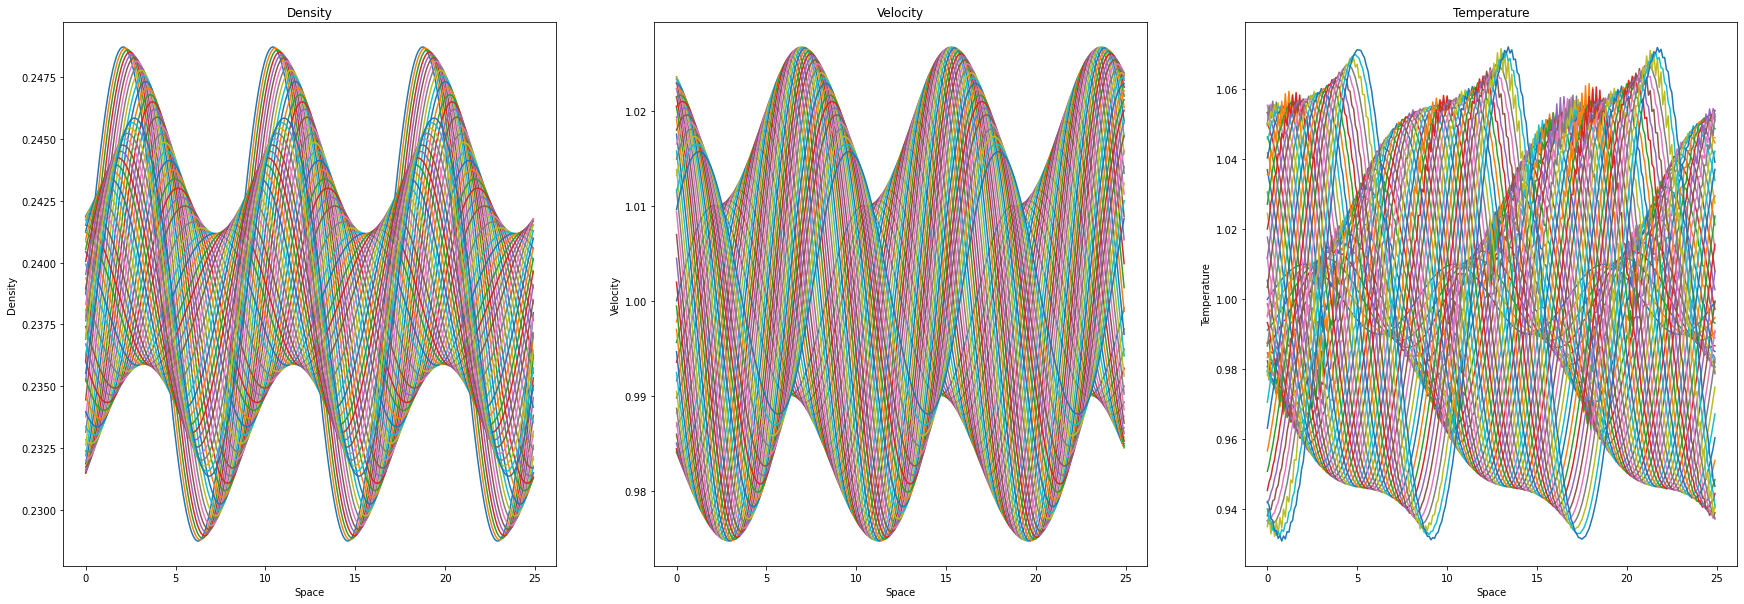

In [11]:
# Line Plots
subplot_figsize = (30,10)
single_plot_figsize = (15,10)
num_time_plots = np.arange(0,len(T))

# fig, ax = plt.subplots(figsize = figsize)
# plt.title("Density")
# plt.xlabel("Space")
# plt.ylabel("Density")

# axins = zoomed_inset_axes(ax[0], 2, loc=10)
# axins.plot(X[0:20],ntot[0:20,num_time_plots])
# # axins.set_xlim(1, 2)
# # axins.set_ylim(1, 2)
# plt.xticks(visible=False)
# plt.yticks(visible=False)
# mark_inset(ax[0], axins, loc1=2, loc2=4, fc="none", ec="0.5")
# plt.draw()
# plt.show()

# fig, ax = plt.subplots(figsize = figsize)
# plt.title("Velocity")
# plt.xlabel("Space")
# plt.ylabel("Velocity")

# fig, ax = plt.subplots(figsize = figsize)
# plt.title("Temperature")
# plt.xlabel("Space")
# plt.ylabel("Temperature")

fig, ax = plt.subplots(1,3, figsize=subplot_figsize)

ax[0].plot(X,ntot[:,num_time_plots])
ax[0].set_title("Density")
ax[0].set_xlabel("Space")
ax[0].set_ylabel("Density")

ax[1].plot(X,vtot[:,num_time_plots])
ax[1].set_title("Velocity")
ax[1].set_xlabel("Space")
ax[1].set_ylabel("Velocity")

ax[2] = plt.plot(X,etot[:,num_time_plots])
# ax[2].set_title("Temperature")
# ax[2].set_xlabel("Space")
# ax[2].set_ylabel("Temperature")

plt.title("Temperature")
plt.xlabel("Space")
plt.ylabel("Temperature")

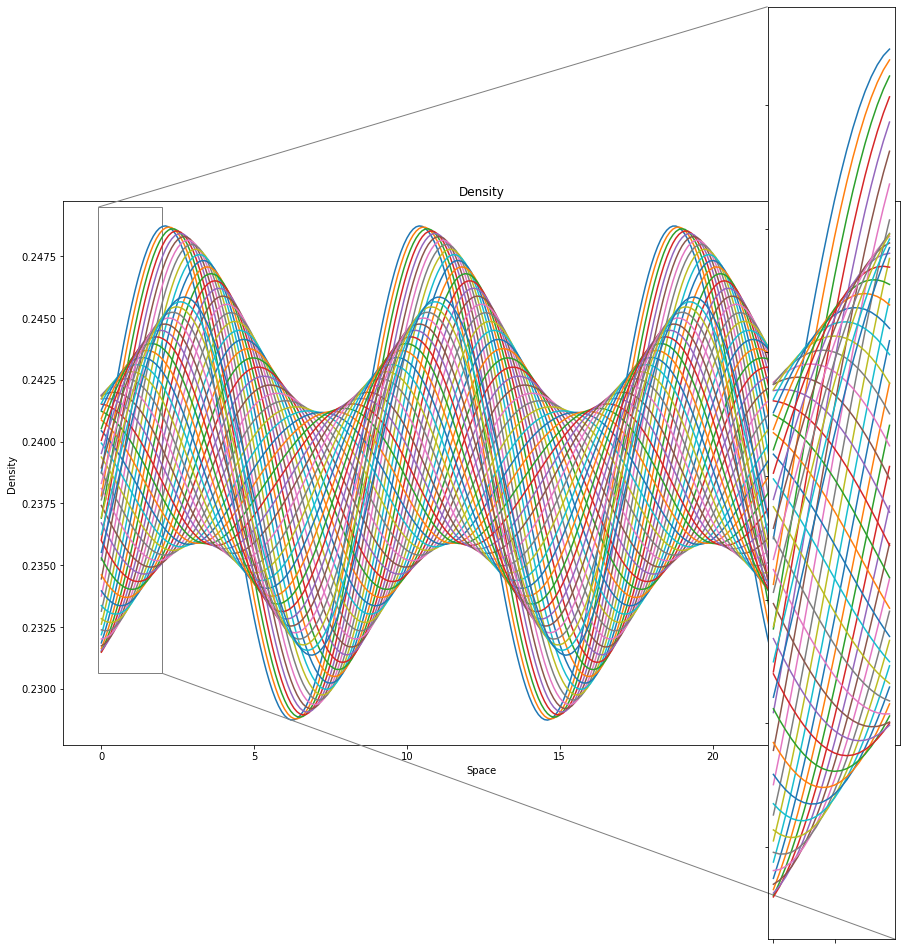

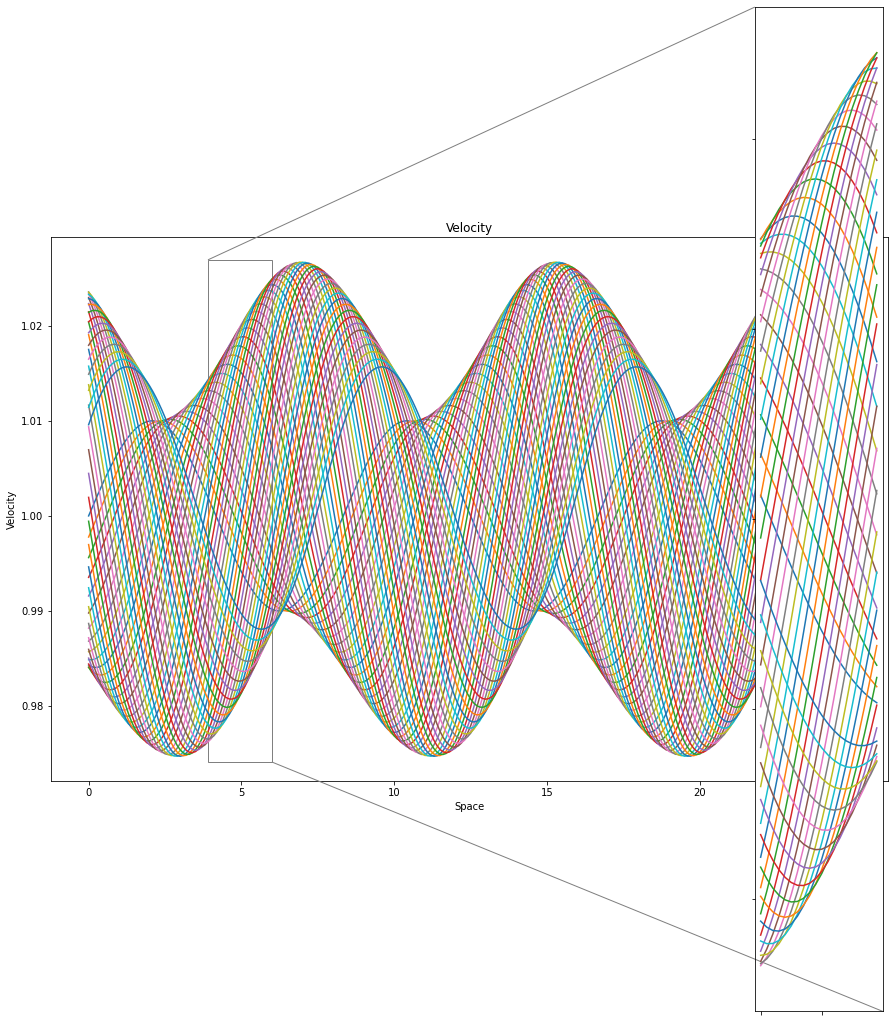

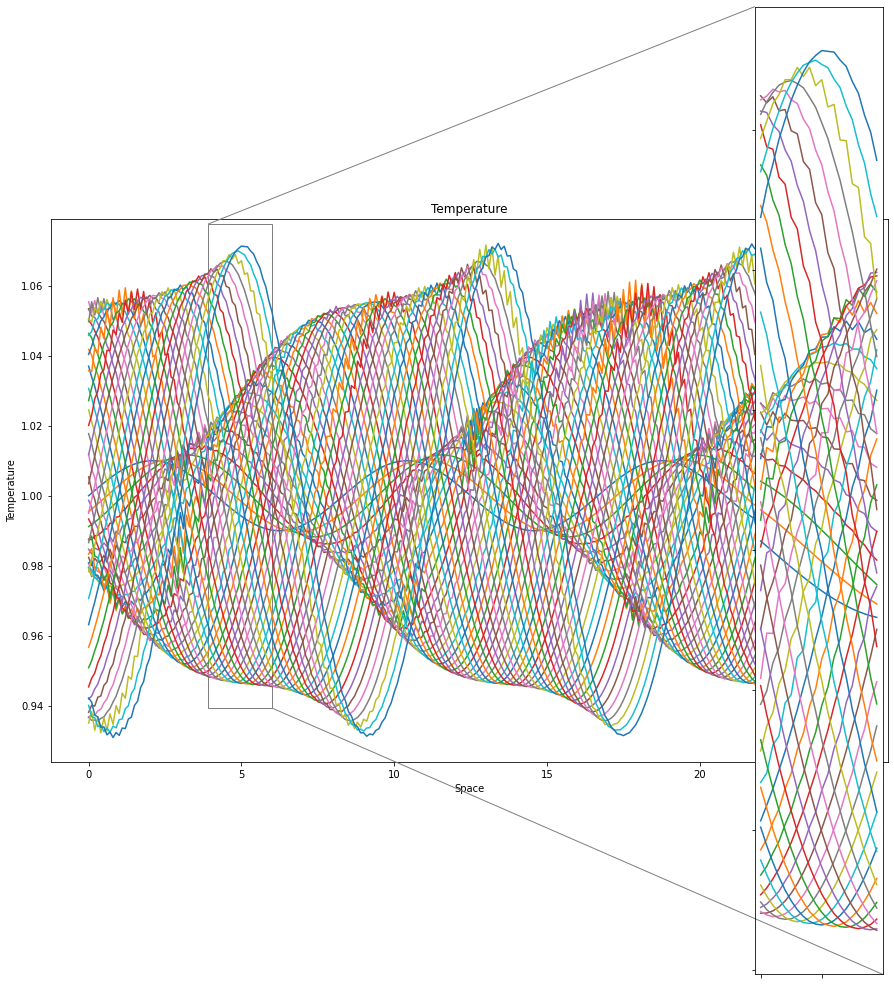

In [12]:
fig, ax = plt.subplots(figsize = single_plot_figsize)
plt.plot(X,ntot[:,num_time_plots])
plt.title("Density")
plt.xlabel("Space")
plt.ylabel("Density")

axins = zoomed_inset_axes(ax, 2, loc=7)
# axins.plot(X[int(Xnum/2 -10):int(Xnum/2 + 10)],ntot[int(Xnum/2 -10):int(Xnum/2 +10),num_time_plots])
axins.plot(X[0:20],ntot[0:20,num_time_plots])
# axins.set_xlim(1, 2)
# axins.set_ylim(1, 2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.draw()
plt.show()


fig, ax = plt.subplots(figsize = single_plot_figsize)
plt.plot(X,vtot[:,num_time_plots])
plt.title("Velocity")
plt.xlabel("Space")
plt.ylabel("Velocity")

axins = zoomed_inset_axes(ax, 2, loc=7)
# axins.plot(X[int(Xnum/2 -10):int(Xnum/2 + 10)],ntot[int(Xnum/2 -10):int(Xnum/2 +10),num_time_plots])
axins.plot(X[40:60],vtot[40:60,num_time_plots])
# axins.set_xlim(1, 2)
# axins.set_ylim(1, 2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.draw()
plt.show()


fig, ax = plt.subplots(figsize = single_plot_figsize)
plt.plot(X,etot[:,num_time_plots])
plt.title("Temperature")
plt.xlabel("Space")
plt.ylabel("Temperature")

axins = zoomed_inset_axes(ax, 2, loc=7)
# axins.plot(X[int(Xnum/2 -10):int(Xnum/2 + 10)],ntot[int(Xnum/2 -10):int(Xnum/2 +10),num_time_plots])
axins.plot(X[40:60],etot[40:60,num_time_plots])
# axins.set_xlim(1, 2)
# axins.set_ylim(1, 2)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")
plt.draw()
plt.show()

Text(0, 0.5, 'Temperature')

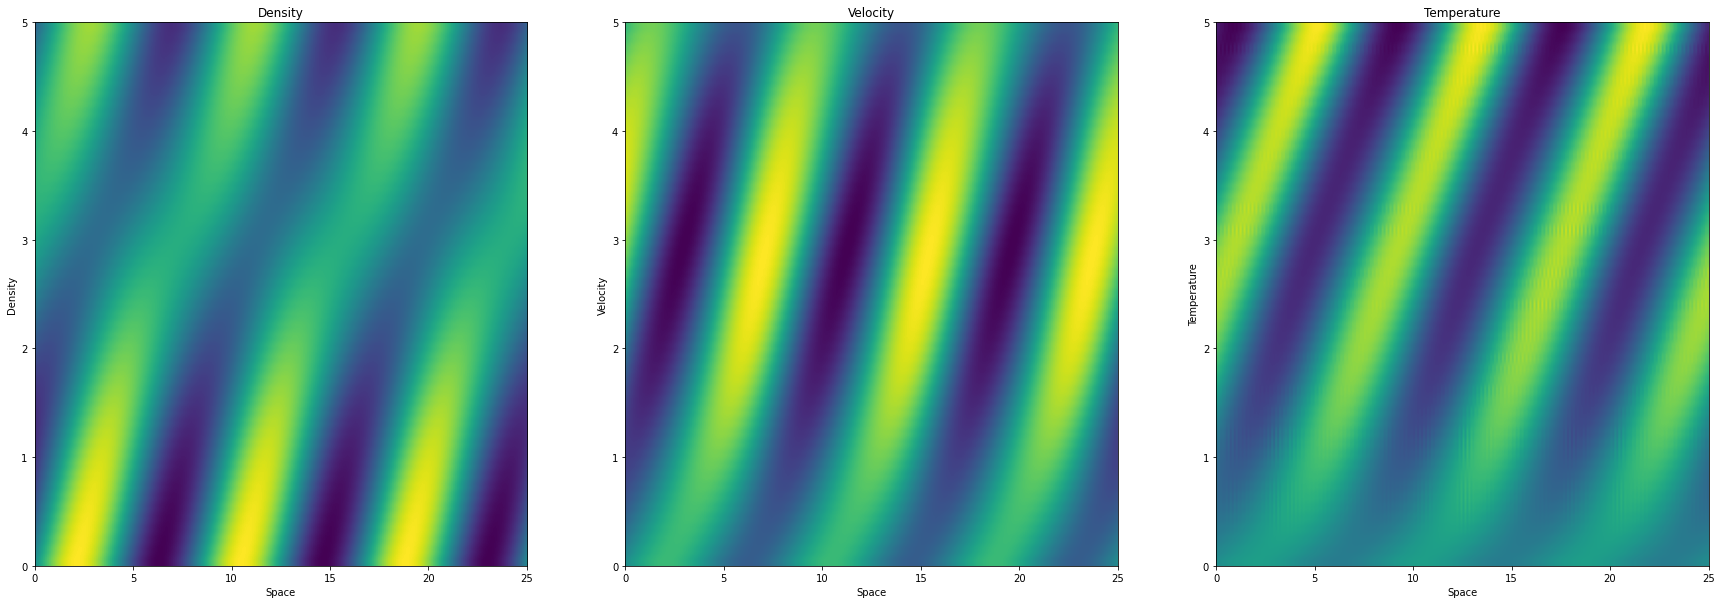

In [13]:
# Colormaps
space_time_domain = [0, Xlngth, 0, Tlngth]

fig, ax = plt.subplots(1,3, figsize=subplot_figsize)
# fig, ax = plt.subplots(figsize = single_plot_figsize)
flip_ntot = np.flip(ntot.T, axis = 0)
plt.imshow(flip_ntot, extent=space_time_domain, aspect='auto', cmap='viridis')
ax[0].imshow(flip_ntot, extent=space_time_domain, aspect='auto', cmap='viridis')
ax[0].set_title("Density")
ax[0].set_xlabel("Space")
ax[0].set_ylabel("Density")
# plt.legend()

# fig, ax = plt.subplots(figsize = single_plot_figsize)
flip_vtot = np.flip(vtot.T, axis = 0)
# plt.imshow(flip_vtot, extent=space_time_domain, aspect='auto', cmap='viridis')
ax[1].imshow(flip_vtot, extent=space_time_domain, aspect='auto', cmap='viridis')
ax[1].set_title("Velocity")
ax[1].set_xlabel("Space")
ax[1].set_ylabel("Velocity")

# plt.legend()

# fig, ax = plt.subplots(figsize = single_plot_figsize)
flip_etot = np.flip(etot.T, axis = 0)
# plt.imshow(flip_etot, extent=space_time_domain, aspect='auto', cmap='viridis')
ax[2].imshow(flip_etot, extent=space_time_domain, aspect='auto', cmap='viridis')
plt.title("Temperature")
plt.xlabel("Space")
plt.ylabel("Temperature")
# plt.legend()

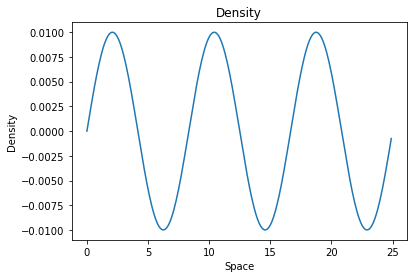

Text(0, 0.5, 'Density')

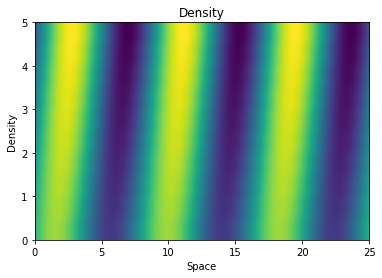

In [14]:
# Plot Initial Condition
plt.plot(X, ntot[:,0]-nmean)
plt.title("Density")
plt.xlabel("Space")
plt.ylabel("Density")
plt.show()

plt.imshow(flip_ntot[0:10], extent=space_time_domain, aspect='auto')
plt.title("Density")
plt.xlabel("Space")
plt.ylabel("Density")

Text(0, 0.5, 'Density')

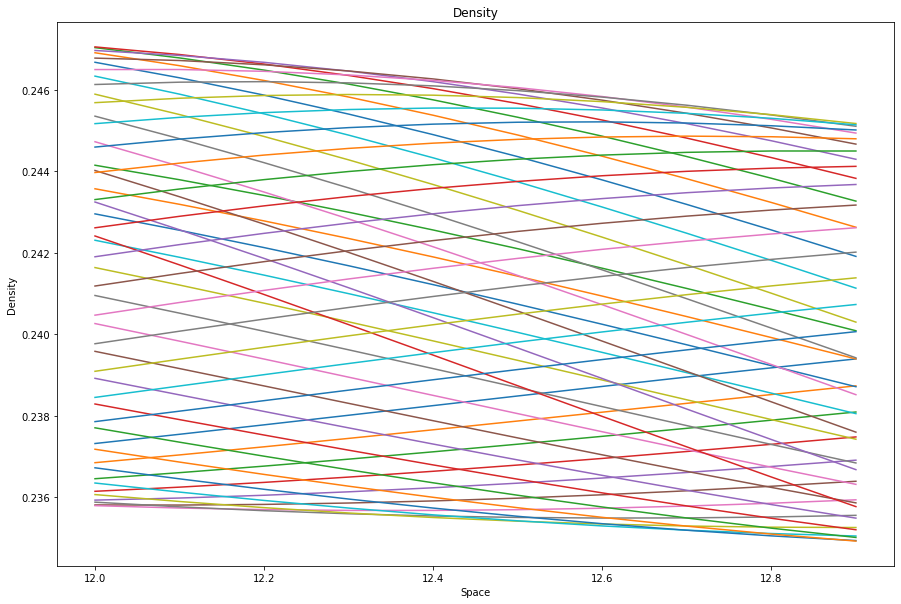

In [15]:
# Plot Boundary Condition
midpoint = int(Xnum/2)
bandwidth = 5

ntot_shift = half_domain_shift(ntot)[midpoint-bandwidth:midpoint+bandwidth]
vtot_shift = half_domain_shift(vtot)[midpoint-bandwidth:midpoint+bandwidth]
X_shift = X[midpoint-bandwidth:midpoint+bandwidth]

fig, ax = plt.subplots(figsize = single_plot_figsize)
plt.plot(X_shift, ntot_shift[0:20])
plt.title("Density")
plt.xlabel("Space")
plt.ylabel("Density")

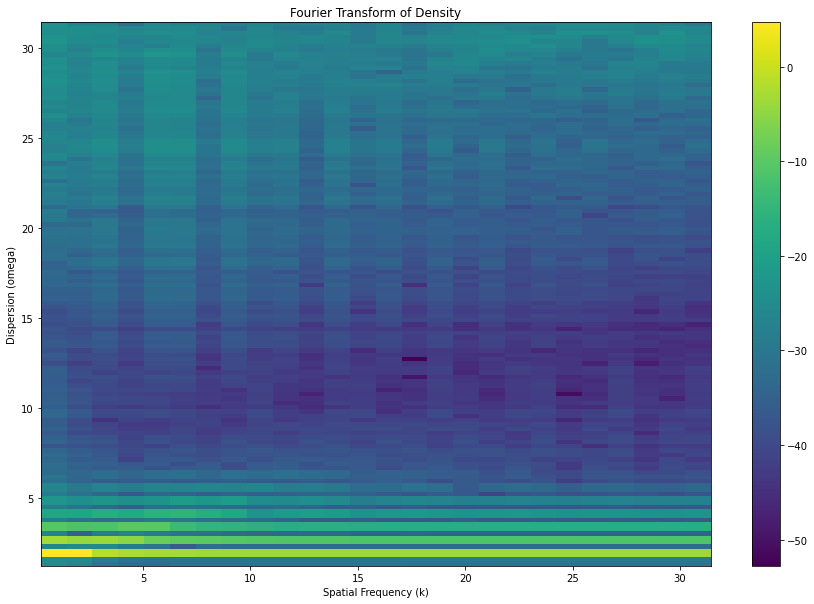

In [16]:
def fft(arr):
    return np.fft.fftshift(np.fft.fft2(arr))

def fold_average_along_axis(arr, axis=0):
    """
    Fold and average an ndarray along the specified axis.

    Parameters:
        array (numpy.ndarray): Input ndarray.
        axis (int, optional): Axis along which to fold and average (default is 0 for rows).

    Returns:
        numpy.ndarray: Folded and averaged result.
    """
    shape = list(arr.shape)
    shape[axis] = (shape[axis] + 1) // 2  # Calculate the size after folding

    left = arr.take(indices=range(0,shape[axis]), axis=axis)
    right = arr.take(indices=range(-shape[axis],0), axis=axis)
    
    fold_right = np.flip(right, axis=axis)
    folded_avg = (left+fold_right)/2
    return folded_avg

centered_ntot = ntot - np.mean(ntot)
nfft = fft(centered_ntot)

min_dt = np.min(np.diff(sol.t))
T_freq_min = 2*np.pi/Tlngth
T_freq_max = np.pi/min_dt
X_freq_min = 2*np.pi/Xlngth
X_freq_max = np.pi/dx

space_time_freq_domain = [X_freq_min, X_freq_max, T_freq_min, T_freq_max]

# structure_factor = np.abs(nfft)**2

# print(structure_factor)

# fig, ax = plt.subplots(figsize = single_plot_figsize)
# fig = plt.figure(figsize = single_plot_figsize)
# plt.imshow(np.log(structure_factor).T, extent=space_time_freq_domain, aspect='auto', cmap='viridis')
# plt.title("Fourier Transform of Density")
# plt.xlabel("Spatial Frequency (k)")
# plt.ylabel("Dispersion (omega)")
# plt.colorbar()

folded_nfft = fold_average_along_axis(nfft, axis=0)
folded_nfft = fold_average_along_axis(folded_nfft, axis=1)

structure_factor = np.abs(folded_nfft)**2
# structure_factor = np.abs(nfft)**2
structure_factor = np.flip(structure_factor,axis=1)

fig = plt.figure(figsize = single_plot_figsize)
plt.imshow(np.log(structure_factor), extent=space_time_freq_domain, aspect='auto', cmap='viridis')
plt.title("Fourier Transform of Density")
plt.xlabel("Spatial Frequency (k)")
plt.ylabel("Dispersion (omega)")
plt.colorbar()

Eigenvalue (0.7596200117802326+0.5638312113884234j): distance from unit circle -0.05399355328161859
Eigenvalue (0.7596200117802326-0.5638312113884234j): distance from unit circle -0.05399355328161859
Eigenvalue (0.808738471774763+0.5178578078988602j): distance from unit circle -0.03966952306490246
Eigenvalue (0.808738471774763-0.5178578078988602j): distance from unit circle -0.03966952306490246
Eigenvalue (0.9192334941592314+0.3887122993664275j): distance from unit circle -0.0019581830088857277
Eigenvalue (0.9192334941592314-0.3887122993664275j): distance from unit circle -0.0019581830088857277
Eigenvalue (0.9727256086908109+0.10751289804206891j): distance from unit circle -0.021350863154566024
Eigenvalue (0.9727256086908109-0.10751289804206891j): distance from unit circle -0.021350863154566024
Eigenvalue (0.9769669512908625+0.17927118216262286j): distance from unit circle -0.006721297586348651
Eigenvalue (0.9769669512908625-0.17927118216262286j): distance from unit circle -0.006721297

C:\Users\chris\anaconda3\lib\site-packages\pydmd\snapshots.py:72: UserWarning: Input data condition number 4184936941233345.5. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
C:\Users\chris\anaconda3\lib\site-packages\pydmd\plotter.py:189: UserWarning: Legend does not support [<matplotlib.lines.Line2D object at 0x0000015499F5EEE0>] instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  plt.legend(


<Figure size 1080x720 with 0 Axes>

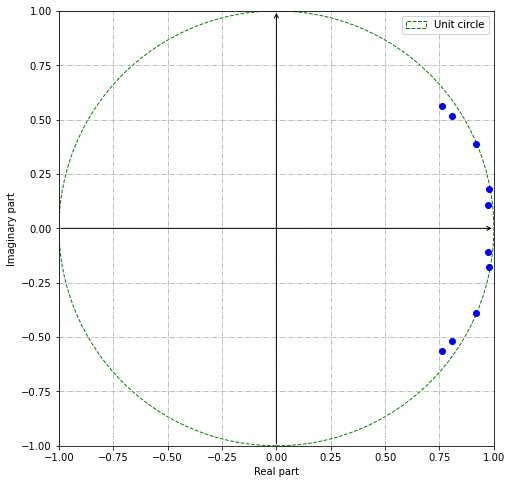

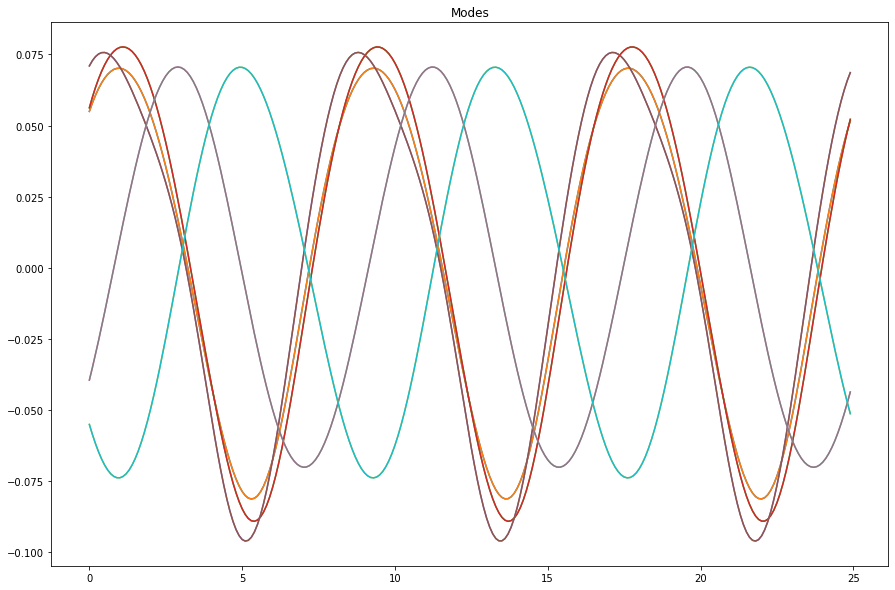

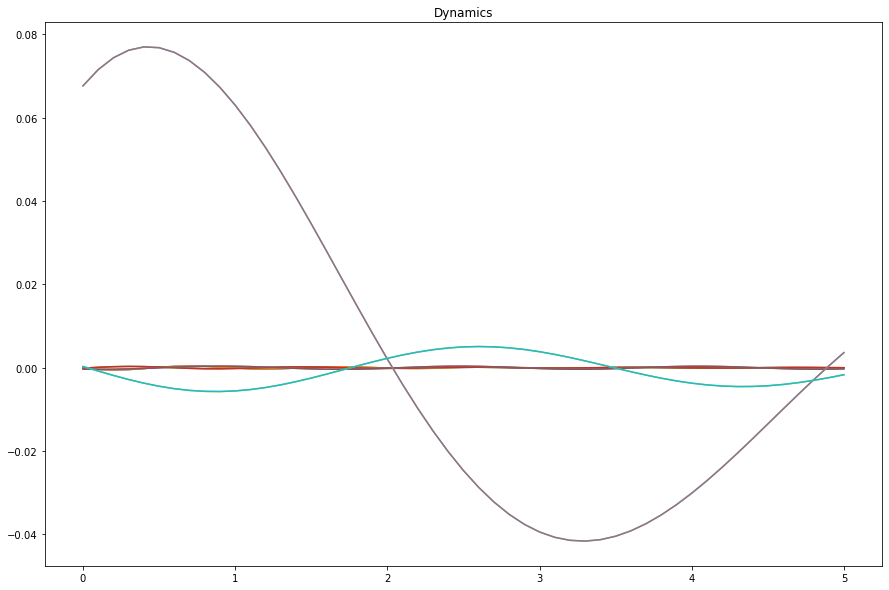

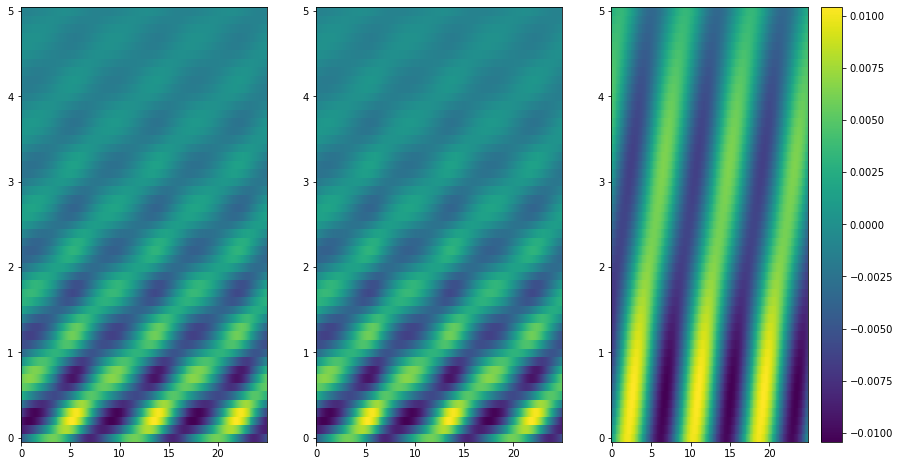

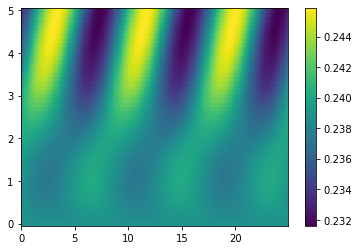

Difference Between DMD Reconstructed Data & Original:  26.958871875996724


In [17]:
# DMD
rank = -1
Xgrid, Tgrid = np.meshgrid(X, T)

def dmd_analysis(data, rank):
    dmd = DMD(svd_rank=rank)  # Use svd_rank=-1 to compute all modes
    dmd.fit(data)
    
    return dmd

dmd_data = dmd_analysis(centered_ntot, rank = 10)

modes = dmd_data.modes
eigenvalues = dmd_data.eigs
dynamics = dmd_data.dynamics
reconstructed_data = dmd_data.reconstructed_data

# Plotting Eigenvalues
fig_eigenvalues = plt.figure(figsize=(15,10))
for eig in eigenvalues:
    print(
        "Eigenvalue {}: distance from unit circle {}".format(
            eig, np.sqrt(eig.imag**2 + eig.real**2) - 1
        )
    )
plot_eigs(dmd_data, show_axes=True, show_unit_circle=True)

# Plot Modes
fig_modes = plt.figure(figsize=(15,10))
for mode in dmd_data.modes.T:
    plt.plot(X, mode.real)
    plt.title("Modes")
plt.show()

# Plot  Dynamics
fig_dynamics = plt.figure(figsize=(15,10))
for dynamic in dmd_data.dynamics:
    plt.plot(T, dynamic.real)
    plt.title("Dynamics")
plt.show()


# Plotting Reconstructed Data
fig_reconstructed_data = plt.figure(figsize=(15, 8))
for n, mode, dynamic in zip(range(131, 133), dmd_data.modes.T, dmd_data.dynamics):
    plt.subplot(n)
    plt.pcolor(Xgrid, Tgrid, (mode.reshape(-1, 1).dot(dynamic.reshape(1, -1))).real.T)

plt.subplot(133)
plt.pcolor(Xgrid, Tgrid, dmd_data.reconstructed_data.T.real)
plt.colorbar()

plt.show()

# Measure Difference Reconstructed & Original Data
dmd_diff = (ntot.T - dmd_data.reconstructed_data.T).real
plt.pcolor(Xgrid, Tgrid, dmd_diff)
fig = plt.colorbar()
plt.show()

print("Difference Between DMD Reconstructed Data & Original: ", np.linalg.norm(dmd_diff))

AttributeError: 'AxesSubplot' object has no attribute 'twiXnum'

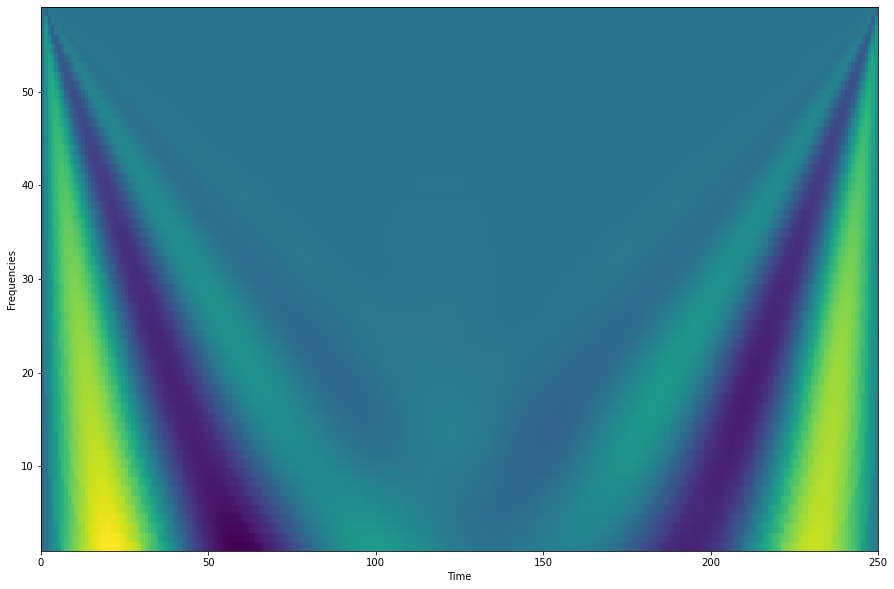

In [18]:
# Wavelet Transformation
wavelet_name = 'morl'
scales = np.arange(1,60)  # TODO: FI

[coefficients, frequencies] = pywt.cwt(ntot[:,10].T, scales, wavelet_name, min_dt)

wavelet_domain = [0, Xnum, scales.min(), scales.max()]

fig, ax = plt.subplots(figsize=single_plot_figsize)
ax.imshow(coefficients, extent=wavelet_domain, aspect='auto', cmap='viridis')
ax.set_ylabel('Frequencies')
ax.set_xlabel('Time')
ax2 = ax.twiXnum()
ax2.set_ylabel('period [s]')
strs = [str(round(p*1e3)/1e3) for p in 1/frequencies]
ax2.set_yticks(np.arange(coefficients.shape[0]), labels=strs);

In [ ]:
import numpy as np
import scipy.signal

def morlet_wavelet_transform(data, scales, dt=1.0):
    """
    Compute the Morlet Wavelet Transformation of a 2D spatio-temporal array.
    
    Parameters:
    - data: 2D NumPy array of shape (T, X), where T is the number of time steps
            and X is the number of spatial points.
    - scales: List of scales for the wavelet transform.
    - dt: Time step between consecutive time points (default=1.0).

    Returns:
    - wavelet_transform: 3D NumPy array of shape (len(scales), T, X), where each
                         slice along the first dimension corresponds to the
                         wavelet transform at a specific scale.
    """
    wavelet_transform = []
    
    for scale in scales:
        # Create the Morlet wavelet
        w = scipy.signal.morlet(data.shape[0], w=scale)
        
        # Convolve the data with the wavelet in the time domain
        wavelet_convolution = np.apply_along_axis(lambda x: np.convolve(x, w, mode='same'), axis=0, arr=data)
        
        # Calculate the wavelet transform in the time-frequency domain
        wavelet_transform.append(wavelet_convolution)
    
    return np.array(wavelet_transform)

# Example usage:
if __name__ == "__main__":
    # Create a sample spatio-temporal data array (T=100, X=64)
    T, X = 100, 64
    data = np.random.randn(T, X)
    print(data.shape)
    data = np.sin(np.ones(X)[:,np.newaxis]+np.ones(T)[np.newaxis,:])
    data += 2*np.sin(3*np.ones(X)[:,np.newaxis]+4*np.ones(T)[np.newaxis,:])
    print(data.shape)
    
    # Define the scales for the wavelet transform
    scales = [1, 2, 4]
    
    # Compute the Morlet Wavelet Transformation
    wavelet_transform = morlet_wavelet_transform(data, scales)
    
    print(wavelet_transform.shape)  # Should print (len(scales), T, X)
    
    for transform in wavelet_transform:
        plt.figure(figsize=single_plot_figsize)
        plt.imshow(np.abs(transform))


In [ ]:
# Forecasting

In [ ]:
# Var(Number)

In [ ]:
# Kernel DMD - Nonlinear DMD